In [128]:
import random
from random import shuffle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
import os
from transformers import TFViTModel, ViTConfig, ViTFeatureExtractor
from pathlib import Path
tf.keras.backend.set_image_data_format('channels_first')
import pygad
import cv2
import pygad.kerasga
from matplotlib import pyplot as plt

In [ ]:
DIRPATH = 'A:\ML_project\dogs_datasets\Experts_train_eval'
SAVEPATH = 'A:\ML_project\Code\Valid_code\Numpy_datasets\Expert'

In [139]:
IMG_SIZE =100

cat = os.listdir(DIRPATH)
CATEGORIES = sorted(cat)
print(CATEGORIES)
def createTrainingData(path_test):
    labels = []
    imgs_array = np.empty((0,100,100,3))
    for folder in os.listdir(path_test):
        class_num  = CATEGORIES.index(folder)
        path = os.path.join(path_test,folder)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img))
            imgs = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
            imgs = cv2.resize(imgs, (IMG_SIZE, IMG_SIZE))
            imgs = imgs.astype('float')
            imgs = np.expand_dims(imgs, axis=0)
            labels.append(class_num)
            imgs_array = np.append(imgs_array,imgs,axis=0)
            #imgs_array = np.stack((imgs_array,imgs))

    return imgs_array,labels




['Adult', 'Senior', 'Young']


In [140]:
images, labels = createTrainingData(DIRPATH)
labels = np.array(labels)
data_inputs = images

In [146]:
np.save(r"A:\ML_project\Code\Valid_code\Numpy_datasets\Expert_dataset\Images.npy", images)

In [150]:
np.save(r"A:\ML_project\Code\Valid_code\Numpy_datasets\Expert_dataset\Labels.npy", labels)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    mode="min",
    restore_best_weights=True,
)

In [ ]:
def fitness_func(solution, sol_idx):
    global data_inputs,labels, model, INIT_WEIGHTS,solution_dict
    print(solution)
    model.set_weights(INIT_WEIGHTS)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    model.fit(
        x=data_inputs[solution],
        y=labels[solution],
        verbose = 1,
        validation_split = 0.1,
        batch_size = 8,
        epochs = 2,
        callbacks = [early_stop]
    )
    predictions = model.predict(data_inputs[solution])
    predictions = np.argmax(predictions,axis=1)
    accuracy =  tf.keras.metrics.Accuracy()
    accuracy.update_state(labels[solution],predictions)
    solution_fitness = accuracy.result().numpy()
    print(solution_fitness)


    return solution_fitness

In [ ]:



# Build the keras model using the functional API.
model=tf.keras.Sequential()

model.add(layers.Conv2D(64,(7,7),activation='selu',input_shape=(100,100,3), padding="same"))
model.add(layers.Conv2D(64,(7,7),activation=tf.nn.leaky_relu,padding="same"))

model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64,(5,5),activation='selu',padding="same"))
model.add(layers.Conv2D(64,(5,5),activation=tf.nn.leaky_relu,padding="same"))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())

model.add(layers.Dense(10, activation='selu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3, activation="softmax"))

INIT_WEIGHTS = model.get_weights()

In [ ]:
# Prepare the PyGAD parameters. Check the documentation for more information: https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#pygad-ga-class
num_generations = 200 # Number of generations.
num_parents_mating = 5 # Number of solutions to be selected as parents in the mating pool.


# Create an instance of the pygad.GA class
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       sol_per_pop =5,
                       num_genes = 100,
                       init_range_low=0,
                       gene_type=int,
                       init_range_high=len(data_inputs)-1,
                       fitness_func=fitness_func)

# Start the genetic algorithm evolution.
ga_instance.run()

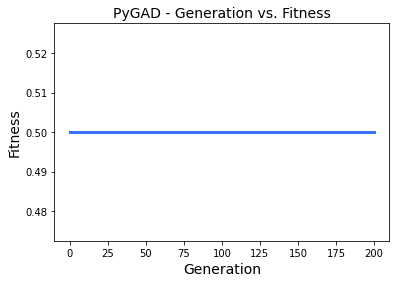

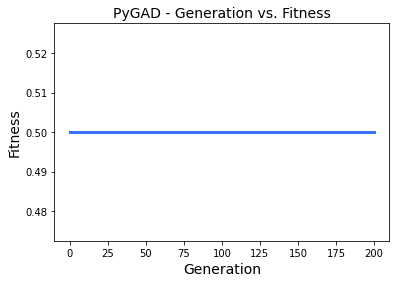

In [119]:
ga_instance.plot_fitness()